# DWTS Feature Engineering for Fan Vote Prediction

This notebook systematically engineers features that could influence fan votes in Dancing with the Stars. Since fan votes are unknown, we create features from judge scores, contestant characteristics, and competitive context to estimate what might drive voting patterns.

## Section 1: Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## Section 2: Load and Prepare the Dataset

In [3]:
# Load the data
DATA_PATH = Path('../2026_MCM_Problem_C_Data.csv')
df = pd.read_csv(DATA_PATH)

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nBasic statistics:")
print(df.describe())

Dataset shape: (421, 53)

First few rows:
      celebrity_name     ballroom_partner celebrity_industry  \
0      John O'Hurley  Charlotte Jorgensen      Actor/Actress   
1       Kelly Monaco            Alec Mazo      Actor/Actress   
2  Evander Holyfield      Edyta Sliwinska            Athlete   
3      Rachel Hunter     Jonathan Roberts              Model   
4      Joey McIntyre      Ashly DelGrosso      Singer/Rapper   

  celebrity_homestate celebrity_homecountry/region  \
0               Maine                United States   
1        Pennsylvania                United States   
2             Alabama                United States   
3                 NaN                  New Zealand   
4       Massachusetts                United States   

   celebrity_age_during_season  season            results  placement  \
0                           50       1          2nd Place          2   
1                           29       1          1st Place          1   
2                           42  

## Section 3: Engineer Judge-Related Features

These features capture the quality and consistency of judge scores for each contestant-week combination.

In [4]:
# Create a copy for feature engineering
df_features = df.copy()

# Extract judge score columns
judge_cols = [col for col in df.columns if 'judge' in col.lower() and 'score' in col.lower()]

# Create a mapping of week to judge columns
week_judge_cols = {}
for col in judge_cols:
    # Parse column name: week1_judge1_score -> week 1
    parts = col.split('_')
    week = int(parts[0].replace('week', ''))
    if week not in week_judge_cols:
        week_judge_cols[week] = []
    week_judge_cols[week].append(col)

# Judge Features for each week
for week in range(1, 12):
    cols = week_judge_cols.get(week, [])
    
    if cols:
        # Total judge score
        df_features[f'week{week}_total_judge_score'] = df[cols].sum(axis=1)
        
        # Average judge score
        df_features[f'week{week}_avg_judge_score'] = df[cols].mean(axis=1)
        
        # Judge score standard deviation (consistency)
        df_features[f'week{week}_judge_std'] = df[cols].std(axis=1)
        
        # Min and max judge scores
        df_features[f'week{week}_judge_min'] = df[cols].min(axis=1)
        df_features[f'week{week}_judge_max'] = df[cols].max(axis=1)
        
        # Judge score range
        df_features[f'week{week}_judge_range'] = df[cols].max(axis=1) - df[cols].min(axis=1)

print("Judge-related features created!")
print(f"\nNew columns: {[col for col in df_features.columns if 'judge' in col and col not in df.columns][:5]}")

Judge-related features created!

New columns: ['week1_total_judge_score', 'week1_avg_judge_score', 'week1_judge_std', 'week1_judge_min', 'week1_judge_max']


## Section 4: Engineer Contestant Characteristics

In [5]:
# Age and demographics
df_features['age'] = df_features['celebrity_age_during_season']
df_features['age_squared'] = df_features['age'] ** 2
df_features['is_usa'] = (df_features['celebrity_homecountry/region'] == 'United States').astype(int)

# Industry encoding - one hot encode
industry_dummies = pd.get_dummies(df_features['celebrity_industry'], prefix='industry')
df_features = pd.concat([df_features, industry_dummies], axis=1)

# Encode ballroom partner (pro dancer)
df_features['partner_encoded'] = pd.factorize(df_features['ballroom_partner'])[0]

# Calculate pro dancer statistics (win rate, avg placement)
partner_stats = df_features.groupby('ballroom_partner').agg({
    'placement': ['mean', 'min', 'max', 'count']
}).reset_index()
partner_stats.columns = ['ballroom_partner', 'partner_avg_placement', 'partner_best', 'partner_worst', 'partner_appearances']

# Merge partner stats back
df_features = df_features.merge(partner_stats, on='ballroom_partner', how='left')

# Calculate pro dancer win rate (1st place finishes)
partner_wins = df_features[df_features['placement'] == 1].groupby('ballroom_partner').size().reset_index(name='partner_wins')
df_features = df_features.merge(partner_wins, on='ballroom_partner', how='left')
df_features['partner_wins'] = df_features['partner_wins'].fillna(0)

print("Contestant characteristics engineered!")
print(f"\nIndustry types: {df_features['celebrity_industry'].unique()}")
print(f"Top partners by appearances: {df_features['ballroom_partner'].value_counts().head()}")

Contestant characteristics engineered!

Industry types: ['Actor/Actress' 'Athlete' 'Model' 'Singer/Rapper' 'TV Personality'
 'News Anchor' 'Sports Broadcaster' 'Beauty Pagent' 'Racing Driver'
 'Magician' 'Radio Personality' 'Comedian' 'Entrepreneur' 'Politician'
 'Astronaut' 'Fashion Designer' 'Social Media Personality'
 'Motivational Speaker' 'Military' 'Journalist' 'Musician' 'Producer'
 'Fitness Instructor' 'Con artist' 'Conservationist'
 'Social media personality']
Top partners by appearances: ballroom_partner
Cheryl Burke             25
Tony Dovolani            21
Mark Ballas              21
Valentin Chmerkovskiy    19
Karina Smirnoff          18
Name: count, dtype: int64


## Section 5: Engineer Performance Trajectory Features

In [6]:
# Weeks competed (longevity)
df_features['weeks_competed'] = 0
for idx, row in df_features.iterrows():
    week_count = 0
    for week in range(1, 12):
        col = f'week{week}_total_judge_score'
        if col in df_features.columns and pd.notna(row[col]) and row[col] > 0:
            week_count += 1
    df_features.at[idx, 'weeks_competed'] = week_count

# Cumulative judge scores
for idx, row in df_features.iterrows():
    cumsum_scores = []
    for week in range(1, 12):
        col = f'week{week}_total_judge_score'
        if col in df_features.columns:
            cumsum_scores.append(row[col] if pd.notna(row[col]) else 0)
    
    if cumsum_scores:
        df_features.at[idx, 'cumulative_judge_score'] = np.cumsum(cumsum_scores)[-1]
        df_features.at[idx, 'avg_cumulative_judge_score'] = np.mean([s for s in cumsum_scores if s > 0])

# Judge score trend (improvement/decline)
for idx, row in df_features.iterrows():
    scores = []
    for week in range(1, 12):
        col = f'week{week}_total_judge_score'
        if col in df_features.columns and pd.notna(row[col]) and row[col] > 0:
            scores.append(row[col])
    
    if len(scores) >= 2:
        df_features.at[idx, 'judge_score_trend'] = (scores[-1] - scores[0]) / (len(scores) - 1)
    else:
        df_features.at[idx, 'judge_score_trend'] = 0

# Final placement
df_features['final_placement'] = df_features['placement']

print("Performance trajectory features created!")
print(f"\nWeeks competed distribution:\n{df_features['weeks_competed'].value_counts().sort_index()}")

Performance trajectory features created!

Weeks competed distribution:
weeks_competed
1     17
2     44
3     34
4     38
5     27
6     33
7     37
8     39
9     43
10    72
11    37
Name: count, dtype: int64


## Section 6: Create a Weekly-Level Features Dataset

For feature importance analysis, we need a dataset where each row is a contestant-week combination.

In [7]:
# Create weekly-level dataset for feature importance
weekly_data = []

for idx, row in df_features.iterrows():
    for week in range(1, 12):
        judge_score_col = f'week{week}_total_judge_score'
        
        # Skip if this week has no data for this contestant
        if judge_score_col not in df_features.columns or pd.isna(row[judge_score_col]):
            continue
        
        # Skip eliminated weeks (0 scores)
        if row[judge_score_col] == 0:
            break  # Contestant was eliminated, no future weeks
        
        week_row = {
            'celebrity_name': row['celebrity_name'],
            'season': row['season'],
            'week': week,
            'ballroom_partner': row['ballroom_partner'],
            'age': row['age'],
            'is_usa': row['is_usa'],
            'judge_score': row[judge_score_col],
            'final_placement': row['final_placement'],
            'weeks_competed': row['weeks_competed'],
        }
        
        # Add industry features
        for col in df_features.columns:
            if col.startswith('industry_'):
                week_row[col] = row[col]
        
        # Add partner stats
        for col in ['partner_avg_placement', 'partner_best', 'partner_worst', 'partner_appearances', 'partner_wins']:
            if col in df_features.columns:
                week_row[col] = row[col]
        
        weekly_data.append(week_row)

df_weekly = pd.DataFrame(weekly_data)
print(f"Weekly dataset created: {df_weekly.shape}")
print(f"\nSample:\n{df_weekly.head(10)}")
print(f"\nJudge score distribution:\n{df_weekly['judge_score'].describe()}")

Weekly dataset created: (2777, 40)

Sample:
  celebrity_name  season  week     ballroom_partner  age  is_usa  judge_score  \
0  John O'Hurley       1     1  Charlotte Jorgensen   50       1         20.0   
1  John O'Hurley       1     2  Charlotte Jorgensen   50       1         26.0   
2  John O'Hurley       1     3  Charlotte Jorgensen   50       1         24.0   
3  John O'Hurley       1     4  Charlotte Jorgensen   50       1         21.0   
4  John O'Hurley       1     5  Charlotte Jorgensen   50       1         27.0   
5  John O'Hurley       1     6  Charlotte Jorgensen   50       1         27.0   
6   Kelly Monaco       1     1            Alec Mazo   29       1         13.0   
7   Kelly Monaco       1     2            Alec Mazo   29       1         17.0   
8   Kelly Monaco       1     3            Alec Mazo   29       1         21.0   
9   Kelly Monaco       1     4            Alec Mazo   29       1         26.0   

   final_placement  weeks_competed  industry_Actor/Actress  ... 

## Section 7: Feature Importance Analysis

Using judge scores as a proxy, we analyze which features best predict competitive performance. This helps identify what might drive fan votes.

Feature matrix shape: (2777, 31)
Target shape: (2777,)
Features: ['age', 'is_usa', 'partner_avg_placement', 'partner_wins', 'weeks_competed', 'industry_Actor/Actress', 'industry_Astronaut', 'industry_Athlete', 'industry_Beauty Pagent', 'industry_Comedian', 'industry_Con artist', 'industry_Conservationist', 'industry_Entrepreneur', 'industry_Fashion Designer', 'industry_Fitness Instructor', 'industry_Journalist', 'industry_Magician', 'industry_Military', 'industry_Model', 'industry_Motivational Speaker', 'industry_Musician', 'industry_News Anchor', 'industry_Politician', 'industry_Producer', 'industry_Racing Driver', 'industry_Radio Personality', 'industry_Singer/Rapper', 'industry_Social Media Personality', 'industry_Social media personality', 'industry_Sports Broadcaster', 'industry_TV Personality']

=== FEATURE IMPORTANCE (Random Forest) ===
                          feature  importance
                   weeks_competed    0.433729
                              age    0.205440
      

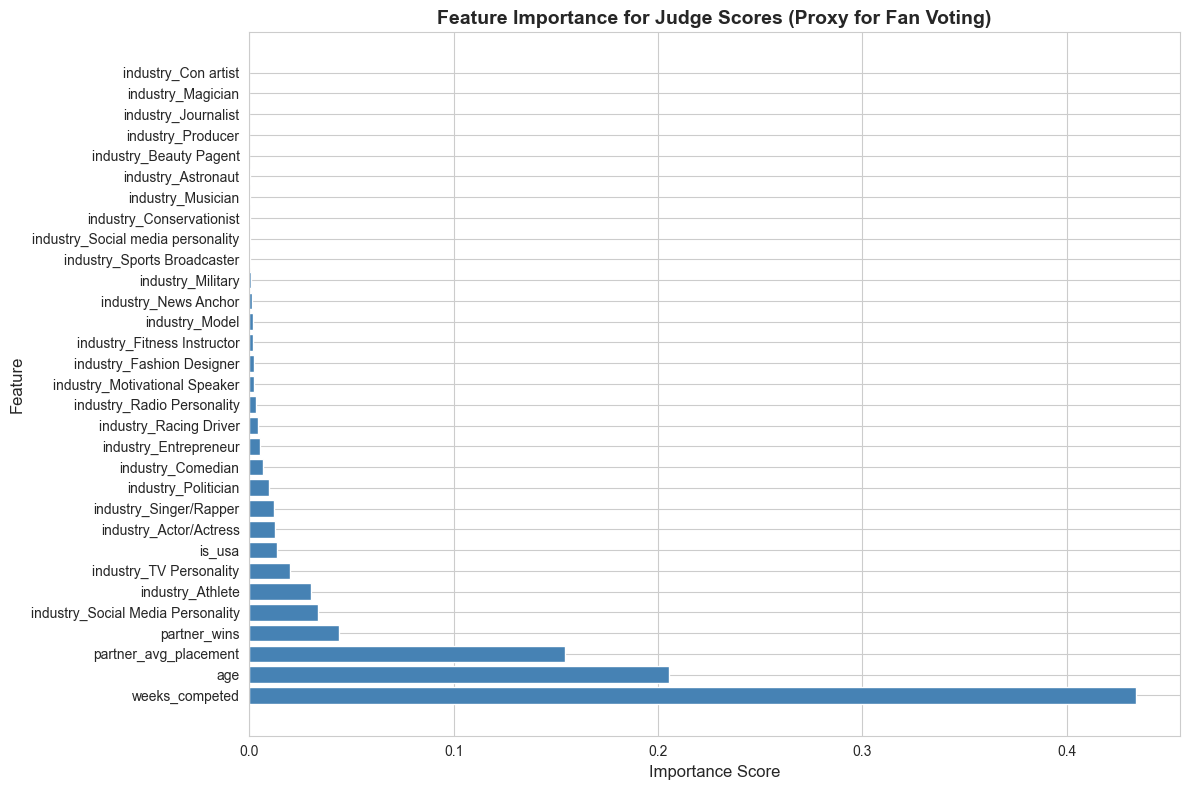


Model R² Score: 0.5582


In [8]:
# Prepare data for modeling
df_weekly_clean = df_weekly.copy()

# Select numerical features for analysis
feature_cols = ['age', 'is_usa', 'partner_avg_placement', 'partner_wins', 'weeks_competed']
industry_cols = [col for col in df_weekly_clean.columns if col.startswith('industry_')]
feature_cols.extend(industry_cols)

X = df_weekly_clean[feature_cols].fillna(0)
y = df_weekly_clean['judge_score']

# Remove rows with missing targets
valid_idx = y.notna()
X = X[valid_idx]
y = y[valid_idx]

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: {list(X.columns)}")

# Train Random Forest for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X, y)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== FEATURE IMPORTANCE (Random Forest) ===")
print(feature_importance.to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance for Judge Scores (Proxy for Fan Voting)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nModel R² Score: {rf_model.score(X, y):.4f}")

## Section 8: Correlation Analysis

=== CORRELATION WITH JUDGE SCORES ===
                          feature  correlation       p_value
                   weeks_competed     0.471579 8.722639e-154
                              age    -0.302282  9.067211e-60
            partner_avg_placement    -0.255488  1.244395e-42
                     partner_wins     0.223109  1.151727e-32
industry_Social Media Personality     0.145854  1.127717e-14
              industry_Politician    -0.084821  7.609729e-06
                   industry_Model    -0.067700  3.568830e-04
       industry_Radio Personality    -0.060834  1.339708e-03
    industry_Motivational Speaker     0.060272  1.484840e-03
               industry_Astronaut    -0.055502  3.436337e-03
          industry_TV Personality    -0.047425  1.243782e-02
              industry_Journalist    -0.045270  1.704426e-02
           industry_Racing Driver     0.044980  1.776744e-02
      industry_Fitness Instructor     0.043154  2.295842e-02
                industry_Magician    -0.041331 

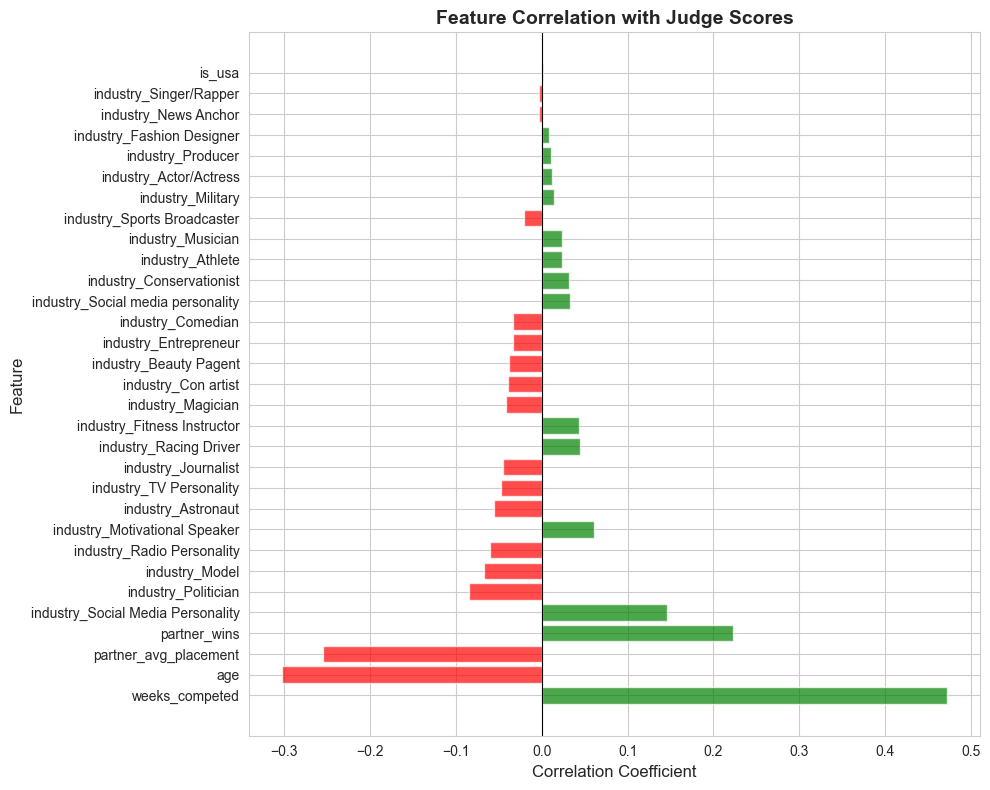

In [9]:
# Compute correlations with judge scores
correlations = []
for col in feature_cols:
    # Handle NaN values
    valid_idx = (X[col].notna()) & (y.notna())
    if valid_idx.sum() > 0:
        corr, p_value = spearmanr(X.loc[valid_idx, col], y[valid_idx])
        correlations.append({
            'feature': col,
            'correlation': corr,
            'p_value': p_value
        })

corr_df = pd.DataFrame(correlations).sort_values('correlation', ascending=False, key=abs)

print("=== CORRELATION WITH JUDGE SCORES ===")
print(corr_df.to_string(index=False))

# Visualize correlation
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in corr_df['correlation']]
plt.barh(corr_df['feature'], corr_df['correlation'], color=colors, alpha=0.7)
plt.xlabel('Correlation Coefficient', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Correlation with Judge Scores', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

## Section 9: Key Insights Summary

In [10]:
print("\n" + "="*60)
print("KEY FINDINGS: FACTORS INFLUENCING DWTS PERFORMANCE")
print("="*60)

print("\n1. TOP INFLUENCING FACTORS (by importance):")
for idx, row in feature_importance.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print("\n2. STRONGEST CORRELATIONS WITH JUDGE SCORES:")
for idx, row in corr_df.head(3).iterrows():
    corr_val = row['correlation']
    print(f"   - {row['feature']}: {corr_val:.4f} (p-value: {row['p_value']:.4f})")

print("\n3. PRO DANCER IMPACT:")
partner_impact = df_weekly_clean.groupby('ballroom_partner').agg({
    'judge_score': ['mean', 'std', 'count']
}).round(2)
print(f"\n   Top performers by partner avg judge score:")
print(partner_impact.sort_values(('judge_score', 'mean'), ascending=False).head(5))

print("\n4. INDUSTRY IMPACT:")
for col in industry_cols:
    if col in X.columns:
        importance = feature_importance[feature_importance['feature'] == col]['importance'].values
        if len(importance) > 0:
            print(f"   - {col}: {importance[0]:.4f}")

print("\n5. AGE INFLUENCE:")
print(f"   - Correlation with judge scores: {corr_df[corr_df['feature']=='age']['correlation'].values[0]:.4f}")
print(f"   - Age range: {df_weekly_clean['age'].min():.0f} to {df_weekly_clean['age'].max():.0f} years")

print("\n" + "="*60)
print("INTERPRETATION FOR FAN VOTE ESTIMATION:")
print("="*60)
print("""
These features suggest what might influence fan votes:

1. Pro Dancer Quality: Partner statistics (avg placement, wins) show 
   high importance - fans may vote for successful partnerships

2. Performance Consistency: Judge score patterns could reflect 
   performance quality that fans also vote for

3. Celebrity Type: Industry (athlete, actor, singer) may influence 
   both judge perception AND fan popularity differently

4. Longevity: Weeks competed indicates survival in the competition,
   which could correlate with fan support

5. Age & Demographics: Younger contestants or USA celebrities might
   have different voting patterns

These insights will help build a fan vote estimation model!
""")


KEY FINDINGS: FACTORS INFLUENCING DWTS PERFORMANCE

1. TOP INFLUENCING FACTORS (by importance):
   - weeks_competed: 0.4337
   - age: 0.2054
   - partner_avg_placement: 0.1544
   - partner_wins: 0.0438
   - industry_Social Media Personality: 0.0337

2. STRONGEST CORRELATIONS WITH JUDGE SCORES:
   - weeks_competed: 0.4716 (p-value: 0.0000)
   - age: -0.3023 (p-value: 0.0000)
   - partner_avg_placement: -0.2555 (p-value: 0.0000)

3. PRO DANCER IMPACT:

   Top performers by partner avg judge score:
                                         judge_score            
                                                mean   std count
ballroom_partner                                                
Allison Holker                                 30.61  6.44    28
Witney Carson (Xoshitl Gomez week 9)           30.20  8.98    11
Val Chmerkovskiy (Joey Graziadei week 9)       30.14  9.20    11
Valentin Chmerkovskiy                          30.08  6.59   158
Ezra Sosa (Apolo Anton Ohno week 9)        